# ML Pipeline

## Step 1: Collect data

In [151]:
# imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *

from sklearn.linear_model import *
from sklearn.neighbors import *
from sklearn.svm import *
from sklearn.naive_bayes import *
from sklearn.tree import *
from sklearn.ensemble import *
from sklearn.discriminant_analysis import *

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


In [152]:
# read the data
red_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')
white_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', sep=';')

## Step 2: Prepare the data

Remove duplicates

In [153]:
# remove lines that have all values duplicated
red_wine.drop_duplicates(inplace=True, ignore_index=True)
white_wine.drop_duplicates(inplace=True, ignore_index=True)

Add missing information and combine data

In [154]:
# add quality_label column
for wine_df in [red_wine, white_wine]:
    # we are creating a new column called "quality_label", we define a range and associate that range with a label
    wine_df['quality_label'] = wine_df['quality'].apply(lambda value: 'low'
    if value <= 5 else 'medium'
    if value <= 7 else 'high')

    # here we are transforming these labels into categrical data type (specific to pandas) instead of simple string
    wine_df['quality_label'] = pd.Categorical(wine_df['quality_label'],
    categories=['low', 'medium', 'high'])

In [155]:
# create a df with all wines

# add color of wine as parameter
red_wine['color'] = 'red'
white_wine['color'] = 'white'

# combine the wine dfs
wine = pd.concat([red_wine, white_wine], ignore_index=True)

# here we are transforming these labels into categrical data type (specific to pandas) instead of simple string
wine['color'] = pd.Categorical(wine['color'],
categories=['red', 'white'])

Adjust feature names

In [156]:
# use the rename method to change all columns names lowercase and add an underscore if they are made of 2 words
for wine_df in [wine, red_wine, white_wine]:
    wine_df.rename(str.lower, axis='columns', inplace=True)  # make the names lowercase
    wine_df.columns = wine_df.columns.str.replace(' ', '_')     # replace space with underscore in column names

Prepare wine data for model training

In [157]:
# prepare wine data for model training
def prepare_wine_data_for_model_training(wine_df):

    # drop quality column
    wine_ml = wine_df.drop(['quality'], axis=1)

    # drop color column if there is only one column
    if len(wine_ml['color'].unique()) < 2:
        wine_ml = wine_ml.drop(['color'], axis=1)
    
    # one hot encode if there is multiple colors
    else:
        # create an instance of OneHotEncoder
        oh_enc = OneHotEncoder(categories=[['red','white']])

        # fit and transform the 'color' column
        encoded_color = oh_enc.fit_transform(wine_ml[['color']])

        # convert the one-hot encoded data to a DataFrame
        encoded_color_df = pd.DataFrame(encoded_color.toarray(), columns=oh_enc.get_feature_names_out(['color']))

        # concatenate the one-hot encoded DataFrame with 'wine_ml'
        wine_ml = pd.concat([wine_ml, encoded_color_df], axis=1)

        # drop the original 'color' column from 'wine_ml'
        wine_ml = wine_ml.drop('color', axis=1)

    # replace the quality labels with numerical values
    quality_codes = {'low' : 0, 'medium' : 1, 'high' : 2}
    wine_ml['quality_label'].replace(quality_codes, inplace=True)
    
    return wine_ml

In [158]:
red_wine_ml = prepare_wine_data_for_model_training(red_wine)
white_wine_ml = prepare_wine_data_for_model_training(white_wine)
wine_ml = prepare_wine_data_for_model_training(wine)

Identify outliers

In [159]:
# let's have a look at the number of outliers

def identify_outliers(df, column, threshold=1.5):
    # Identify potential outliers in a DataFrame column using the Interquartile Range (IQR) method.
    # Returns a DataFrame with rows containing potential outliers based on the specified column.

    # claculate IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # make a df with only outliers
    outliers = (df[column] < Q1 - threshold * IQR) | (df[column] > Q3 + threshold * IQR)
    outliers_df = df[outliers]
    return outliers_df

In [160]:
def count_outliers(wine):

    # make dict to store the data
    outliers = {}

    # claculate amount of outliers for each feature
    for feature in wine.describe().columns:
        outliers[feature] = len(identify_outliers(wine, feature))

    # convert the data to a pd df
    outliers_df = pd.DataFrame(list(outliers.items()), columns=['feature', 'quantity'])

    return outliers_df

In [161]:
print("RED WINE outliers amount")

red_outliers_df = count_outliers(red_wine_ml)

# print the sorted data
red_outliers_df.sort_values(by='quantity', ascending=False)

RED WINE outliers amount


,feature,quantity
3,residual_sugar,126
4,chlorides,87
9,sulphates,55
6,total_sulfur_dioxide,45
0,fixed_acidity,41
7,density,35
8,ph,28
5,free_sulfur_dioxide,26
1,volatile_acidity,19
10,alcohol,12


In [162]:
# chlorides seem to be a strong outlier in both
# residual sugar in red wine
# acidity related parameters in white wine

In [163]:
print("WHITE WINE outliers amount")

white_outliers_df = count_outliers(white_wine_ml)

# print the sorted data
white_outliers_df.sort_values(by='quantity', ascending=False)


WHITE WINE outliers amount


,feature,quantity
2,citric_acid,223
4,chlorides,178
1,volatile_acidity,133
0,fixed_acidity,106
9,sulphates,96
8,ph,46
5,free_sulfur_dioxide,44
3,residual_sugar,16
6,total_sulfur_dioxide,14
7,density,6


Visualize outliers

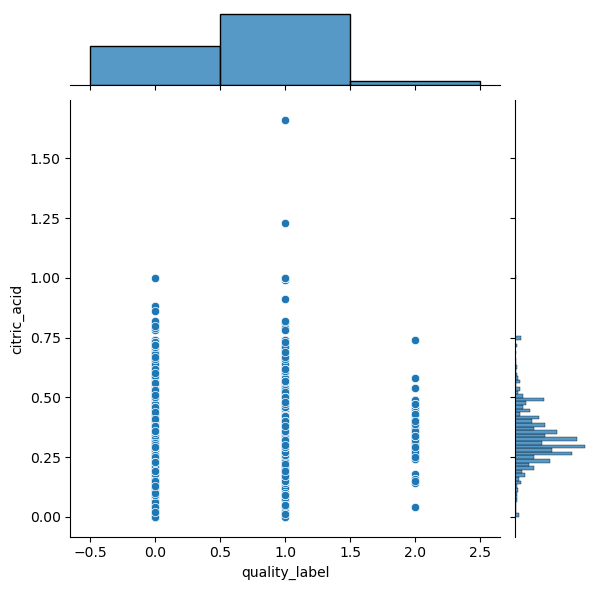

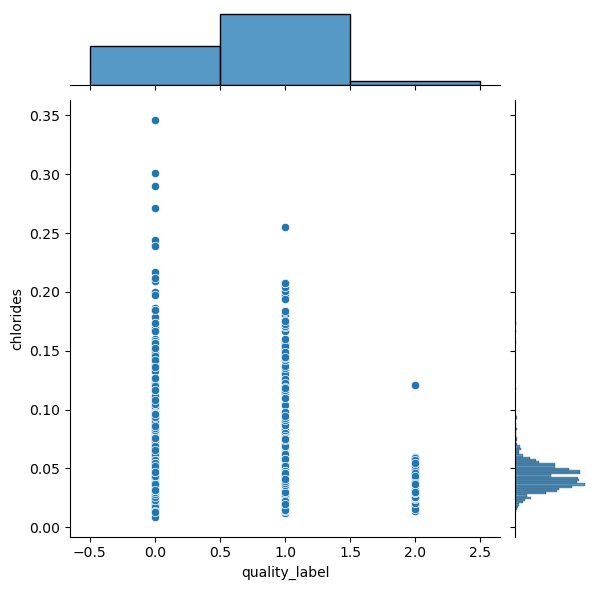

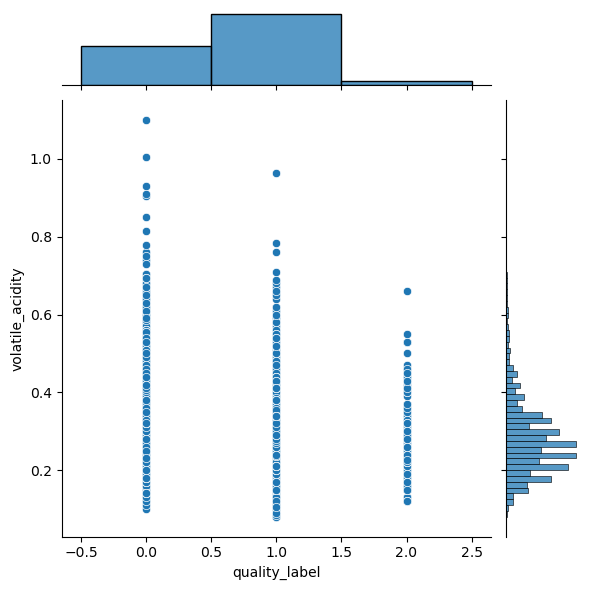

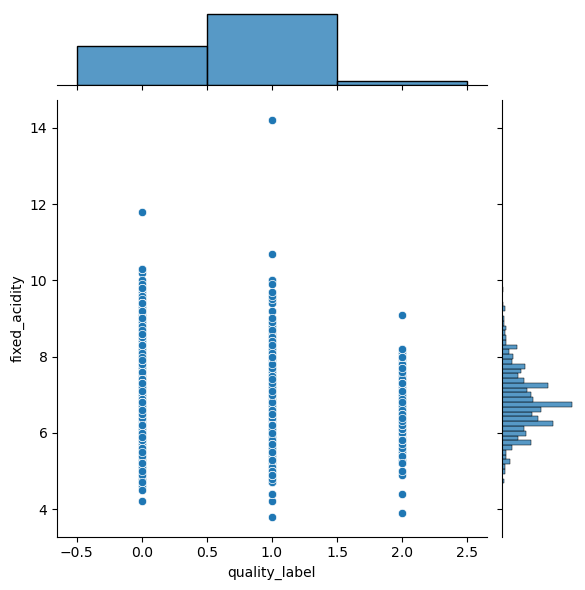

In [164]:
for feature in white_outliers_df.sort_values(by='quantity', ascending=False)['feature'][:4]:

    # jointplot: essentially combine two different distribution plots. two variables.
    sns.jointplot(y=feature, x='quality_label', data=white_wine_ml)

Make outlier tables

Remove outliers

In [165]:
def make_outlier_table(wine_ml):

    wine_outliers_df = count_outliers(wine_ml)

    outlier_tabeles = []

    for feature in wine_outliers_df.sort_values(by='quantity', ascending=False)['feature'][:4]:

        outlier_tabeles.append(identify_outliers(wine_ml, feature, threshold=1.5))

    outlier_table = pd.concat(outlier_tabeles)

    outlier_table.drop_duplicates(inplace=True)

    return outlier_table

In [166]:
outlier_tabeles = []

for feature in white_outliers_df.sort_values(by='quantity', ascending=False)['feature'][:4]:

    outlier_tabeles.append(identify_outliers(white_wine_ml, feature, threshold=1.5))

In [167]:
outlier_tabele = pd.concat(outlier_tabeles)
outlier_tabele

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality_label
10,8.3,0.420,0.62,19.25,0.040,41.0,172.0,1.00020,2.98,0.67,9.7,0
12,6.3,0.480,0.04,1.10,0.046,30.0,99.0,0.99280,3.24,0.36,9.6,1
47,6.8,0.200,0.59,0.90,0.147,38.0,132.0,0.99300,3.05,0.38,9.1,1
54,7.0,0.470,0.07,1.10,0.035,17.0,151.0,0.99100,3.02,0.34,10.5,0
56,6.2,0.350,0.03,1.20,0.064,29.0,120.0,0.99340,3.22,0.54,9.1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3776,4.7,0.335,0.14,1.30,0.036,69.0,168.0,0.99212,3.47,0.46,10.5,0
3861,4.4,0.320,0.39,4.30,0.030,31.0,127.0,0.98904,3.46,0.36,12.8,2
3862,3.9,0.225,0.40,4.20,0.030,29.0,118.0,0.98900,3.57,0.36,12.8,2
3865,4.7,0.785,0.00,3.40,0.036,23.0,134.0,0.98981,3.53,0.92,13.8,1


In [168]:
outlier_tabele.drop_duplicates(inplace=True)

In [169]:
outlier_tabele['quality_label'].value_counts(normalize=True)

quality_label
0    0.584416
1    0.393321
2    0.022263
Name: proportion, dtype: float64

In [170]:
outlier_tabele

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality_label
10,8.3,0.420,0.62,19.25,0.040,41.0,172.0,1.00020,2.98,0.67,9.7,0
12,6.3,0.480,0.04,1.10,0.046,30.0,99.0,0.99280,3.24,0.36,9.6,1
47,6.8,0.200,0.59,0.90,0.147,38.0,132.0,0.99300,3.05,0.38,9.1,1
54,7.0,0.470,0.07,1.10,0.035,17.0,151.0,0.99100,3.02,0.34,10.5,0
56,6.2,0.350,0.03,1.20,0.064,29.0,120.0,0.99340,3.22,0.54,9.1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3591,4.7,0.145,0.29,1.00,0.042,35.0,90.0,0.99080,3.76,0.49,11.3,1
3634,9.0,0.200,0.33,3.50,0.049,10.0,40.0,0.99440,3.14,0.36,9.8,1
3776,4.7,0.335,0.14,1.30,0.036,69.0,168.0,0.99212,3.47,0.46,10.5,0
3861,4.4,0.320,0.39,4.30,0.030,31.0,127.0,0.98904,3.46,0.36,12.8,2


In [171]:
white_wine_ml.drop(outlier_tabele.index, inplace=True)

In [172]:
white_wine_ml

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality_label
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,1
4,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.99490,3.18,0.47,9.6,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3956,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,1
3957,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,0
3958,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,1
3959,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,1


Split data

In [173]:
X = white_wine_ml.drop(['quality_label'], axis=1) # features
y = white_wine_ml['quality_label']  # target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [174]:
X

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9
4,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.99490,3.18,0.47,9.6
...,...,...,...,...,...,...,...,...,...,...,...
3956,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2
3957,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6
3958,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4
3959,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8


In [175]:
y

0       1
1       1
2       1
3       1
4       1
       ..
3956    1
3957    0
3958    1
3959    1
3960    1
Name: quality_label, Length: 3422, dtype: category
Categories (3, int64): [0, 1, 2]

Feature scaling

In [176]:
model = RandomForestClassifier()

kfold = KFold(n_splits=10, shuffle=True, random_state=0)

# Perform K-fold cross-validation and print the accuracy for each fold
fold_accuracies = cross_val_score(model, X, y, cv=kfold)
for i, accuracy in enumerate(fold_accuracies, 1):
    print(f'Fold {i} Accuracy: {accuracy:.4f}')

# Print the mean accuracy across all folds
print(f'Mean Accuracy: {np.mean(fold_accuracies):.4f}')

Fold 1 Accuracy: 0.7289
Fold 2 Accuracy: 0.7405
Fold 3 Accuracy: 0.7368
Fold 4 Accuracy: 0.7544
Fold 5 Accuracy: 0.7573
Fold 6 Accuracy: 0.7515
Fold 7 Accuracy: 0.7135
Fold 8 Accuracy: 0.7485
Fold 9 Accuracy: 0.7515
Fold 10 Accuracy: 0.7456
Mean Accuracy: 0.7428


In [177]:
# initialize the model
forest = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=0)
forest.fit(X_train, y_train.ravel())

# make predictions on the test set
y_pred = forest.predict(X_test)

# evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)

Accuracy: 0.7255
Confusion Matrix:
 [[128 102   0]
 [ 69 369   0]
 [  0  17   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.56      0.60       230
           1       0.76      0.84      0.80       438
           2       0.00      0.00      0.00        17

    accuracy                           0.73       685
   macro avg       0.47      0.47      0.47       685
weighted avg       0.70      0.73      0.71       685



/Users/michalpasternak/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michalpasternak/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michalpasternak/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [198]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Assuming you have your data loaded into X and y

# Set up K-fold cross-validation with K=5 (you can adjust this)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the model
forest = RandomForestClassifier(n_estimators=200, max_features=2)

# Lists to store metrics across folds
accuracy_list = []
conf_matrix_list = []

# Perform K-fold cross-validation
for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model on the training data
    forest.fit(X_train, y_train.ravel())

    # Make predictions on the test set
    y_pred = forest.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Append metrics to lists
    accuracy_list.append(accuracy)
    conf_matrix_list.append(conf_matrix)

# Print the average metrics across all folds
print(f"Average Accuracy: {np.mean(accuracy_list):.4f}")

# Calculate the average confusion matrix
average_conf_matrix = np.mean(conf_matrix_list, axis=0)
print("Average Confusion Matrix:\n", average_conf_matrix)

# Optionally, you can also print the individual confusion matrices for each fold
for i, conf_matrix in enumerate(conf_matrix_list, 1):
    print(f"\nConfusion Matrix - Fold {i}:\n", conf_matrix)


Average Accuracy: 0.7411
Average Confusion Matrix:
 [[1.052e+02 1.014e+02 0.000e+00]
 [5.120e+01 4.014e+02 4.000e-01]
 [4.000e-01 2.380e+01 6.000e-01]]

Confusion Matrix - Fold 1:
 [[117 103   0]
 [ 55 386   0]
 [  0  23   1]]

Confusion Matrix - Fold 2:
 [[107 107   0]
 [ 59 389   0]
 [  1  21   1]]

Confusion Matrix - Fold 3:
 [[ 93  95   0]
 [ 52 418   0]
 [  1  25   0]]

Confusion Matrix - Fold 4:
 [[104 104   0]
 [ 40 409   2]
 [  0  25   0]]

Confusion Matrix - Fold 5:
 [[105  98   0]
 [ 50 405   0]
 [  0  25   1]]


In [179]:
red_outlier_tabele = make_outlier_table(red_wine_ml)
red_wine_ml.drop(red_outlier_tabele.index, inplace=True)

In [180]:
X = red_wine_ml.drop(['quality_label'], axis=1) # features
y = red_wine_ml['quality_label']  # target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [194]:
# Assuming you have your data loaded into X and y

# Set up K-fold cross-validation with K=5 (you can adjust this)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the model
forest = RandomForestClassifier(n_estimators=200, max_features=4, random_state=42)

# Lists to store metrics across folds
accuracy_list = []
conf_matrix_list = []

# Perform K-fold cross-validation
for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model on the training data
    forest.fit(X_train, y_train.ravel())

    # Make predictions on the test set
    y_pred = forest.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Append metrics to lists
    accuracy_list.append(accuracy)
    conf_matrix_list.append(conf_matrix)

# Print the average metrics across all folds
print(f"Average Accuracy: {np.mean(accuracy_list):.4f}")

# Calculate the average confusion matrix
average_conf_matrix = np.mean(conf_matrix_list, axis=0)
print("Average Confusion Matrix:\n", average_conf_matrix)

# Optionally, you can also print the individual confusion matrices for each fold
for i, conf_matrix in enumerate(conf_matrix_list, 1):
    print(f"\nConfusion Matrix - Fold {i}:\n", conf_matrix)


Average Accuracy: 0.7352
Average Confusion Matrix:
 [[108.8  97.8   0. ]
 [ 58.8 393.6   0.6]
 [  0.4  23.6   0.8]]

Confusion Matrix - Fold 1:
 [[121  99   0]
 [ 67 374   0]
 [  0  23   1]]

Confusion Matrix - Fold 2:
 [[114 100   0]
 [ 65 382   1]
 [  1  21   1]]

Confusion Matrix - Fold 3:
 [[ 96  92   0]
 [ 56 414   0]
 [  1  25   0]]

Confusion Matrix - Fold 4:
 [[105 103   0]
 [ 49 400   2]
 [  0  24   1]]

Confusion Matrix - Fold 5:
 [[108  95   0]
 [ 57 398   0]
 [  0  25   1]]


In [182]:
white_wine_ml['quality_label'].value_counts(normalize=True)

quality_label
1    0.661894
0    0.301870
2    0.036236
Name: proportion, dtype: float64

In [183]:
# TODO's:
# include feature scaling
# include feature importance


Feature: fixed_acidity, Score: 0.05877
Feature: volatile_acidity, Score: 0.11545
Feature: citric_acid, Score: 0.07875
Feature: residual_sugar, Score: 0.06330
Feature: chlorides, Score: 0.05988
Feature: free_sulfur_dioxide, Score: 0.09229
Feature: total_sulfur_dioxide, Score: 0.08232
Feature: density, Score: 0.06670
Feature: ph, Score: 0.07285
Feature: sulphates, Score: 0.07218
Feature: alcohol, Score: 0.23495
Feature: color_red, Score: 0.00044
Feature: color_white, Score: 0.00212


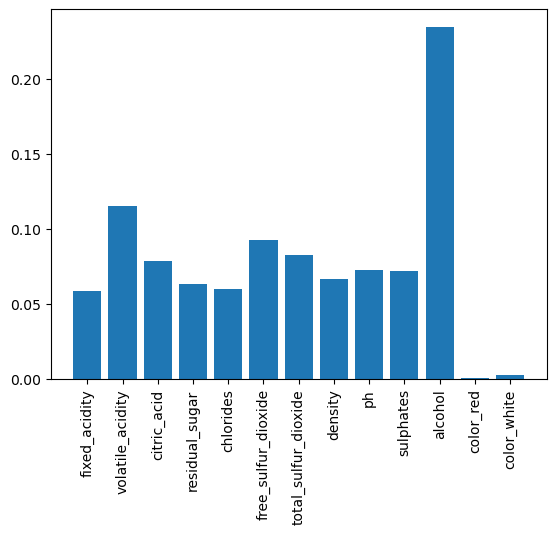

In [184]:
# decision tree for feature importance on a regression problem
# define dataset
X = wine_ml.drop(['quality_label'], axis=1) # features
y = wine_ml['quality_label']  # target variable

# define the model
model = DecisionTreeRegressor()

# fit the model
model.fit(X, y)

# get importance
importance = model.feature_importances_

# Get feature names
feature_names = X.columns

# Summarize feature importance
for feature, score in zip(feature_names, importance):
    print('Feature: %s, Score: %.5f' % (feature, score))

# Plot feature importance
plt.bar(feature_names, importance)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

Feature: fixed_acidity, Score: 0.05534
Feature: volatile_acidity, Score: 0.11682
Feature: citric_acid, Score: 0.06099
Feature: residual_sugar, Score: 0.01546
Feature: chlorides, Score: 0.08441
Feature: free_sulfur_dioxide, Score: 0.05435
Feature: total_sulfur_dioxide, Score: 0.08370
Feature: density, Score: 0.05938
Feature: ph, Score: 0.06217
Feature: sulphates, Score: 0.15116
Feature: alcohol, Score: 0.25622


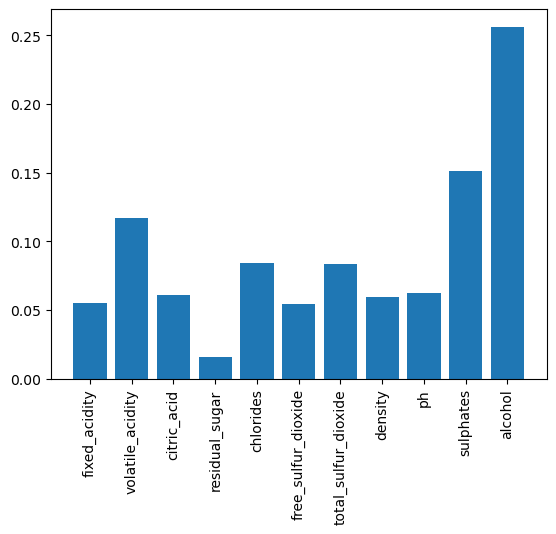

In [185]:
# decision tree for feature importance on a regression problem
# define dataset
X = red_wine_ml.drop(['quality_label'], axis=1) # features
y = red_wine_ml['quality_label']  # target variable

# define the model
model = DecisionTreeRegressor()

# fit the model
model.fit(X, y)

# get importance
importance = model.feature_importances_
importance_red = importance

# Get feature names
feature_names = X.columns

# Summarize feature importance
for feature, score in zip(feature_names, importance):
    print('Feature: %s, Score: %.5f' % (feature, score))

# Plot feature importance
plt.bar(feature_names, importance)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

Feature: fixed_acidity, Score: 0.06038
Feature: volatile_acidity, Score: 0.09133
Feature: citric_acid, Score: 0.06770
Feature: residual_sugar, Score: 0.07015
Feature: chlorides, Score: 0.08885
Feature: free_sulfur_dioxide, Score: 0.12059
Feature: total_sulfur_dioxide, Score: 0.07928
Feature: density, Score: 0.08935
Feature: ph, Score: 0.07472
Feature: sulphates, Score: 0.06535
Feature: alcohol, Score: 0.19231


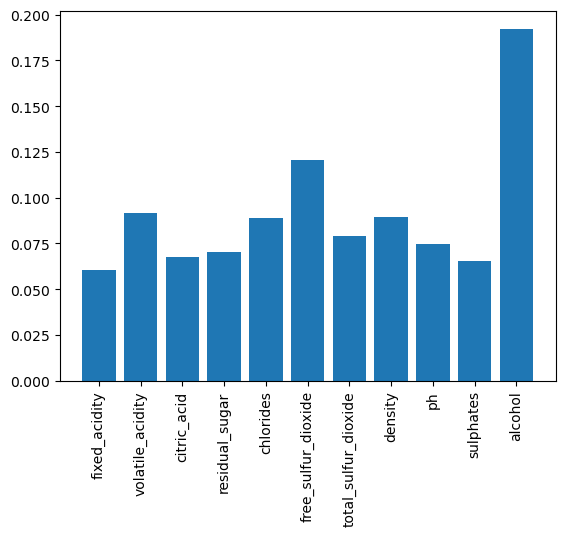

In [186]:
# decision tree for feature importance on a regression problem
# define dataset
X = white_wine_ml.drop(['quality_label'], axis=1) # features
y = white_wine_ml['quality_label']  # target variable

# define the model
model = DecisionTreeRegressor()

# fit the model
model.fit(X, y)

# get importance
importance = model.feature_importances_
importance_white = importance

# Get feature names
feature_names = X.columns

# Summarize feature importance
for feature, score in zip(feature_names, importance):
    print('Feature: %s, Score: %.5f' % (feature, score))

# Plot feature importance
plt.bar(feature_names, importance)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()